# Import python packages

In [1]:
# the following packages need to be installed first
import pandas as pd
import numpy as np
from copy import deepcopy
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
from cobra import Model, Reaction, Metabolite
from cobra.util.array import create_stoichiometric_matrix
from cobra.sampling import sample
from cobra.flux_analysis import flux_variability_analysis
from sklearn.utils import resample

# Function to construct metabolic model by parsing texts

In [2]:
def read_metabolic_model_from_texts (filename):
    df_mets = pd.read_excel(filename, index_col=0, sheet_name='Metabolites')
    df_rxns = pd.read_excel(filename, index_col=0, sheet_name='Reactions')

    # initiate a model object
    model = Model('mammalian cell model')

    # add metabolites
    metabolite_objects = {}
    for met_id in df_mets.index:
        curr_met_obj = Metabolite(met_id, name=df_mets.loc[met_id,'Name'], compartment=df_mets.loc[met_id,'Compartment'])
        metabolite_objects[met_id] = curr_met_obj
    
    # add reactions
    for rxn_id in df_rxns.index:
        reaction = Reaction(rxn_id)
        reaction.name = df_rxns.loc[rxn_id,'Name']

        # get directionality of the reaction
        formula = df_rxns.loc[rxn_id,'Formula']
        direction = None
        if '<-->' in formula:
            reaction.lower_bound = -100
            reaction.upper_bound = 100
            direction = '<-->'
        elif '-->' in formula:
            reaction.lower_bound = 0
            reaction.upper_bound = 100
            direction = '-->'
        elif '<--' in formula:
            reaction.lower_bound = -100
            reaction.upper_bound = 0
            direction = '<--'
        else:
            print('unknown reaction directionality.')
            raise

        # get stoichiometric coefficients of reactants and products
        S_dict = {}

        reactants = formula.split(direction)[0]
        for combo in reactants.split('+'):
            coef = combo.split(')')[0].split('(')[1].strip()
            met_id = combo.split(')')[1].strip()
            if met_id in S_dict.keys():
                print('multiple occurance of %s in the reaction.' % (met_id))
                raise
            else:
                if met_id in metabolite_objects.keys():
                    S_dict[metabolite_objects[met_id]] = -float(coef)
                else:
                    print('unknown metabolite %s.' % (met_id))
                    raise
                    
        products = formula.split(direction)[1]
        for combo in products.split('+'):
            if ')' in combo:
                coef = combo.split(')')[0].split('(')[1].strip()
                met_id = combo.split(')')[1].strip()
                if met_id in S_dict.keys():
                    print('multiple occurance of %s in the reaction.' % (met_id))
                    raise
                else:
                    if met_id in metabolite_objects.keys():
                        S_dict[metabolite_objects[met_id]] = float(coef)
                    else:
                        print('unknown metabolite %s.' % (met_id))
                        raise

        # add metabolites to the reaction
        reaction.add_metabolites(S_dict)
        model.add_reactions([reaction])
    
    # if reaction with "biomass" exists, set it as the objective function
    for rxn in model.reactions:
        if rxn.id.lower() == 'biomass':
            model.objective = 'biomass'
            break
    
    return model

# Function to add flux constraints from Deepti's data

In [3]:
def add_flux_constraints(models, fn_ysi, fn_atp, err_model, cells_per_gram=1e9):
    
    #---------------
    # read YSI data
    #---------------
    df_ysi = pd.read_excel(fn_ysi)
    df_ysi = df_ysi[['Celltype','Replicate','Glucose','Lactate','Glutamine','Glutamate']]
    for met in ['Glucose','Lactate','Glutamine','Glutamate']:
        df_ysi[met] = df_ysi[met]*cells_per_gram*1e-9
    df_ysi = df_ysi.groupby(by=['Celltype'],as_index=False).agg({'Glucose': ['mean', err_model],
                                                                 'Lactate': ['mean', err_model],
                                                                 'Glutamine': ['mean', err_model],
                                                                 'Glutamate': ['mean', err_model]})
    df_ysi.columns = ['Celltype',
                      'glc_mean','glc_err',
                      'lac_mean','lac_err',
                      'gln_mean','gln_err',
                      'glu_mean','glu_err']
    df_ysi.set_index('Celltype',inplace=True)
    
    for ct in df_ysi.index:
        for met_id in ['glc','lac','gln','glu']:
            models[ct].reactions.get_by_id('ex_'+met_id).lower_bound = df_ysi.loc[ct,met_id+'_mean']-df_ysi.loc[ct,met_id+'_err']
            models[ct].reactions.get_by_id('ex_'+met_id).upper_bound = df_ysi.loc[ct,met_id+'_mean']+df_ysi.loc[ct,met_id+'_err']
            
            # test
            max_growth = models[ct].slim_optimize()
            if str(max_growth) == 'nan':
                return None
      
    #-----------------------------
    # read oxygen consumption rate
    #-----------------------------
    df_atp = pd.read_excel(fn_atp)
    df_atp['ATP OCR (pmol/cell/min)'] = -df_atp['ATP OCR (pmol/cell/min)']*60*cells_per_gram*1e-9
    df_atp = df_atp.groupby(by=['Celltype'],as_index=False).agg({'ATP OCR (pmol/cell/min)': ['mean', err_model]})
    df_atp.columns = ['Celltype','o2_mean','o2_err']
    df_atp.set_index('Celltype',inplace=True)

    for ct in df_atp.index:
        models[ct].reactions.get_by_id('ex_o2').lower_bound = df_atp.loc[ct,'o2_mean']-df_atp.loc[ct,'o2_err']
        models[ct].reactions.get_by_id('ex_o2').upper_bound = df_atp.loc[ct,'o2_mean']+df_atp.loc[ct,'o2_err']
        
        # test
        max_growth = models[ct].slim_optimize()
        if str(max_growth) == 'nan':
            return None
        
    return models

# Build the data-constrained model for each cell type

In [6]:
# read base model (before appylinig data constraints)
filename = 'mammalian_cell_model_final.xlsx'
model = read_metabolic_model_from_texts (filename)
model.solver = 'cplex'

# make model copys
models = {}
models['Parental'] = deepcopy(model)
models['BrM2'] = deepcopy(model)
models['LM2'] = deepcopy(model)

# add data constraints
fn_ysi = 'YSI.xlsx'
fn_atp = 'Seahorse_atp.xlsx'
models_w_constraints = add_flux_constraints(deepcopy(models), fn_ysi, fn_atp, 'sem', cells_per_gram=1e9)

# Flux sampling

In [7]:
# run flux sampling
flux_samples = {}
for ct,model in models_w_constraints.items():
    s = sample(model, 10000, processes=12)
    flux_samples.update({ct : s})
    
# save flux samples
flux_samples['Parental'].to_csv('flux_samples_parental.csv')
flux_samples['BrM2'].to_csv('flux_samples_BrM2.csv')
flux_samples['LM2'].to_csv('flux_samples_LM2.csv')

# Plot flux distributions

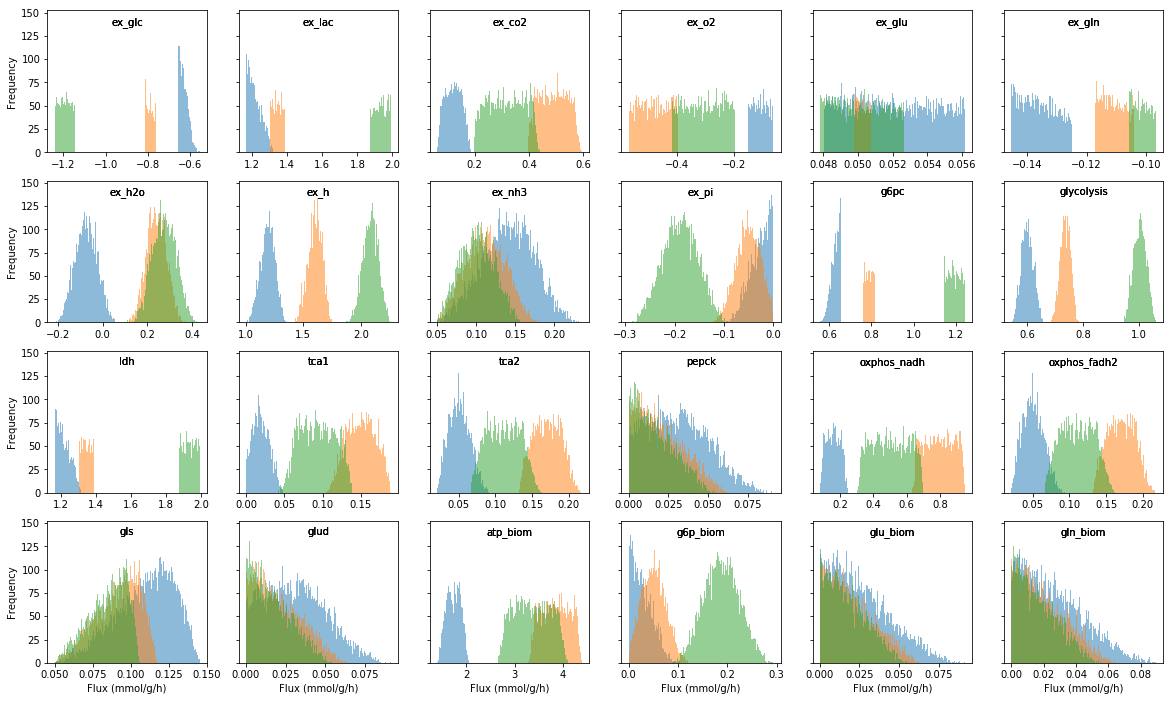

In [8]:
fig, ax = plt.subplots(4,6,sharey=True)
fig.set_size_inches(20,12)

for index_c, ct in enumerate(['Parental','BrM2','LM2']):
    s = flux_samples[ct]
    for index_rxn, rxn in enumerate(s.columns):
        i = int(index_rxn / 6)
        j = index_rxn % 6
        ax[i,j].hist(s[rxn],bins=200, density=False, alpha = 0.5)
        if j==0:
            ax[i,j].set_ylabel('Frequency')
        if i==3:
            ax[i,j].set_xlabel('Flux (mmol/g/h)')        
        ax[i,j].text(.5,.9,rxn,horizontalalignment='center',transform=ax[i,j].transAxes)

plt.show()
fig.savefig('flux_distribution.svg', format='svg', dpi=600)

# Calculate median flux across random samples

In [9]:
df_fs_parental_median = flux_samples['Parental'].median().to_frame()
df_fs_parental_median.columns = ['Parental']
df_fs_BrM2_median = flux_samples['BrM2'].median().to_frame()
df_fs_BrM2_median.columns = ['BrM2']
df_fs_LM2_median = flux_samples['LM2'].median().to_frame()
df_fs_LM2_median.columns = ['LM2']
df_fs_median = pd.merge(df_fs_parental_median,df_fs_BrM2_median,left_index=True,right_index=True)
df_fs_median = pd.merge(df_fs_median,df_fs_LM2_median,left_index=True,right_index=True)
df_fs_median.to_csv('flux_samples_median.csv')

# Resample flux ratio of BrM2/Parental and LM2/Parental

In [10]:
flux_ratio_brm2 = pd.DataFrame(columns = flux_samples['Parental'].columns)
flux_ratio_lm2 = pd.DataFrame(columns = flux_samples['Parental'].columns)
for rxn in flux_samples['Parental'].columns:
    x=resample(list(flux_samples['Parental'][rxn]))
    y=resample(list(flux_samples['BrM2'][rxn]))
    z=resample(list(flux_samples['LM2'][rxn]))
    flux_ratio_brm2[rxn] = [b/a for a, b in zip(x, y)]
    flux_ratio_lm2[rxn] = [c/a for a, c in zip(x, z)]

# Calculate median flux ratio and map the ratio onto blue-black-red colormap

In [11]:
# calculate median flux ratio
df_flux_ratio_median_brm2 = flux_ratio_brm2.median().to_frame()
df_flux_ratio_median_brm2.columns = ['BrM2/Parental']
df_flux_ratio_median_lm2 = flux_ratio_lm2.median().to_frame()
df_flux_ratio_median_lm2.columns = ['LM2/Parental']
df_flux_ratio_median = pd.merge(df_flux_ratio_median_brm2,df_flux_ratio_median_lm2,left_index=True,right_index=True)

# calculate log2 of median flux ratio
df_flux_ratio_median['Log2(BrM2/Parental)'] = np.log2(df_flux_ratio_median['BrM2/Parental'])
df_flux_ratio_median['Log2(LM2/Parental)'] = np.log2(df_flux_ratio_median['LM2/Parental'])

# map log2(flux ratio) to color
minima = -2 # lower end of colormap
maxima = 2  # upper end of colormap

norm = matplotlib.colors.Normalize(vmin=minima, vmax=maxima, clip=True)
mapper = cm.ScalarMappable(norm=norm, cmap= LinearSegmentedColormap.from_list('BkR',['blue','black','red']))

BrM2relativecolor = []
for v in list(df_flux_ratio_median['Log2(BrM2/Parental)']):
    BrM2relativecolor.append(mapper.to_rgba(v)[0:3])
    
LM2relativecolor = []
for v in list(df_flux_ratio_median['Log2(LM2/Parental)']):
    LM2relativecolor.append(mapper.to_rgba(v)[0:3])
    
df_flux_ratio_median['BrM2/Parental Color'] = BrM2relativecolor
df_flux_ratio_median['LM2/Parental Color'] = LM2relativecolor

# save to file
df_flux_ratio_median.to_csv('resampled_flux_ratio_median_and_color.csv')

/usr/local/lib/python3.7/site-packages/pandas/core/series.py:679 RuntimeWarning: invalid value encountered in log2


# Draw blue-black-red colormap

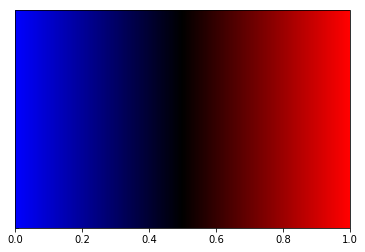

In [13]:
fig, ax = plt.subplots()
cmap= LinearSegmentedColormap.from_list('BkR',['blue','black','red'])
s = ax.scatter(0, 0, cmap=cmap)
matplotlib.colorbar.ColorbarBase(ax=ax, cmap=cmap, orientation="horizontal")
plt.show()
fig.savefig('colorbar.svg', format='svg', dpi=600)

# Function to plot distribution of flux ratio

In [14]:
def plot_distribution_of_flux_ratio(rxn, xlim_brm2, xlim_lm2, bins=200):
    fig, ax = plt.subplots(1,2,sharey=True)
    fig.set_size_inches(10,4)

    # left panel: BrM2/Parental
    _ = ax[0].hist(np.log2(flux_ratio_brm2[rxn]), bins=bins)
    ax[0].plot([np.log2(flux_ratio_brm2[rxn].median()),np.log2(flux_ratio_brm2[rxn].median())],[0,150],'r--') # median
    ax[0].set_xticks([xlim_brm2[0],(xlim_brm2[0]+xlim_brm2[1])/2,xlim_brm2[1]])
    ax[0].set_yticks([0,50,100,150])
    _ = ax[0].set_xlim(xlim_brm2)
    _ = ax[0].set_ylim([0,150])
    _ = ax[0].set_xlabel('%s flux (mmol/gDW/h)'%(rxn))
    _ = ax[0].set_ylabel('Frequency')
    _ = ax[0].set_title('BrM2/Parental')

    # right panel: LM2/Parental
    _ = ax[1].hist(np.log2(flux_ratio_lm2[rxn]), bins=bins)
    ax[1].plot([np.log2(flux_ratio_lm2[rxn].median()),np.log2(flux_ratio_lm2[rxn].median())],[0,150],'r--') # median
    ax[1].set_xticks([xlim_lm2[0],(xlim_lm2[0]+xlim_lm2[1])/2,xlim_lm2[1]])
    ax[1].set_yticks([0,50,100,150])
    _ = ax[1].set_xlim(xlim_lm2)
    _ = ax[1].set_ylim([0,150])
    _ = ax[1].set_xlabel('%s flux (mmol/gDW/h)'%(rxn))
    _ = ax[1].set_title('LM2/Parental')

    fig.savefig('flux_ratio_dist_%s.svg'%(rxn), format='svg', dpi=600)

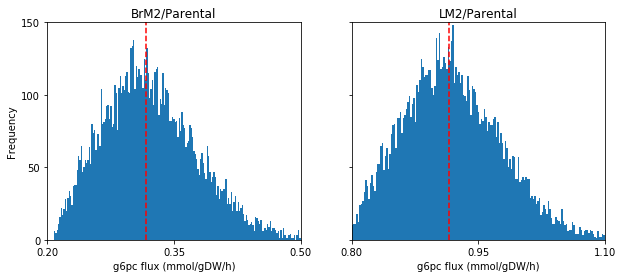

In [15]:
# g6pc
plot_distribution_of_flux_ratio('g6pc', [0.2,0.5], [0.8,1.1])

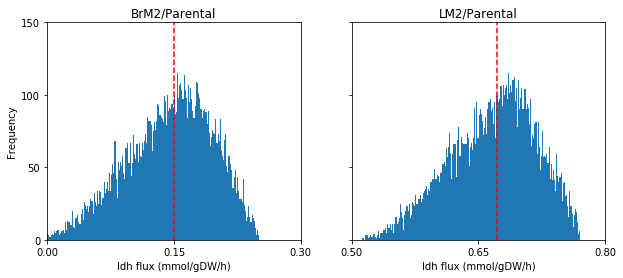

In [16]:
# ldh
plot_distribution_of_flux_ratio('ldh', [0,0.3], [0.5,0.8])

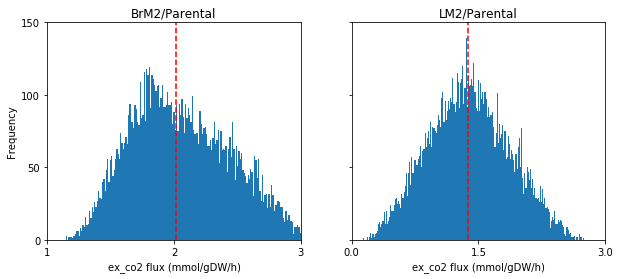

In [17]:
# ex_co2
plot_distribution_of_flux_ratio('ex_co2', [1,3], [0,3])

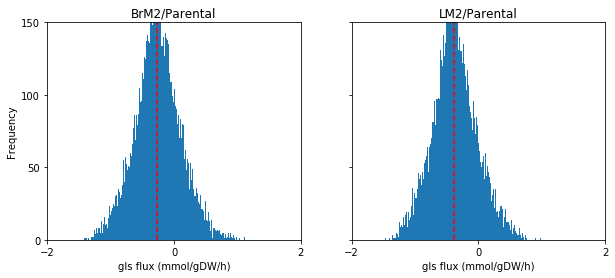

In [18]:
# gls
plot_distribution_of_flux_ratio('gls', [-2,2], [-2,2])

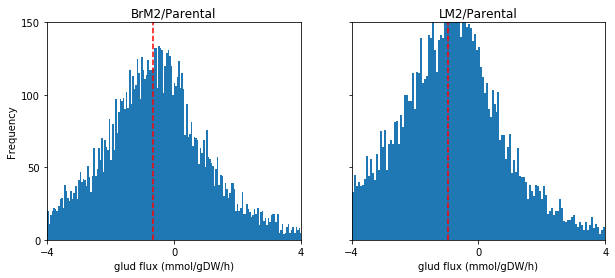

In [19]:
# glud
plot_distribution_of_flux_ratio('glud', [-4,4], [-4,4], bins=500)

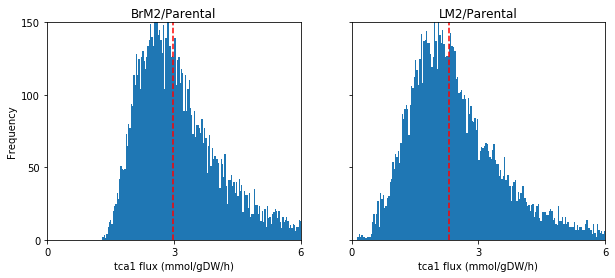

In [20]:
# tca1
plot_distribution_of_flux_ratio('tca1', [0,6], [0,6], bins=500)

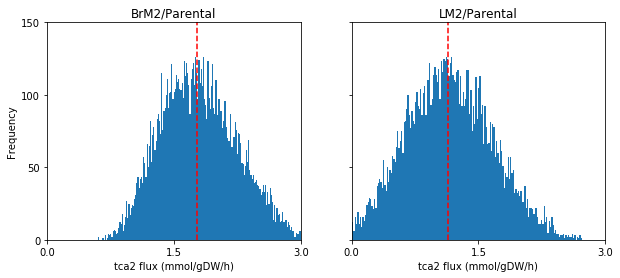

In [21]:
# tca2
plot_distribution_of_flux_ratio('tca2', [0,3], [0,3])

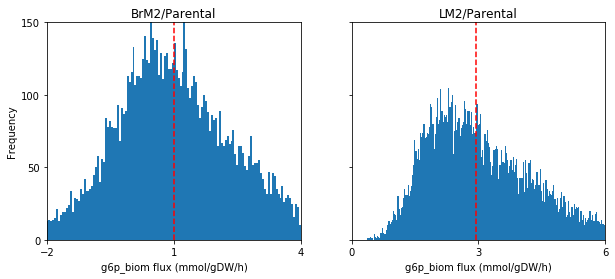

In [22]:
# g6p_biom
plot_distribution_of_flux_ratio('g6p_biom', [-2,4], [0,6], bins=500)

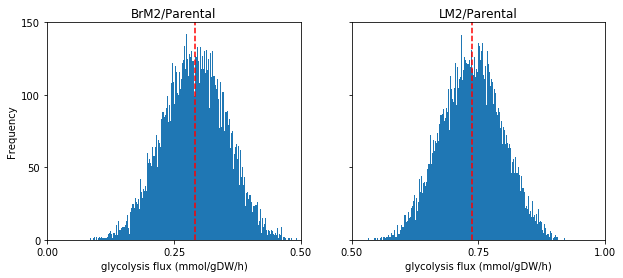

In [23]:
# glycolysis
plot_distribution_of_flux_ratio('glycolysis', [0,0.5], [0.5,1])